In [21]:
# note: same thing for REPL
# note: we use this instead of magic because `black` will otherwise fail to format
#
# Enable autoreload to automatically reload modules when they change

from IPython import get_ipython

# do this so that formatter not messed up
ipython = get_ipython()
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

# Import commonly used libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# graphics
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# type annotation
import jaxtyping
from jaxtyping import Float, Int, jaxtyped
from typeguard import typechecked as typechecker

# more itertools
import more_itertools as mi

# itertools
import itertools
import collections

# tensor manipulation
import einops

import transformer_lens

# automatically apply jaxtyping
# %load_ext jaxtyping
# %jaxtyping.typechecker typeguard.typechecked

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# From:
#
# https://arena3-chapter1-transformer-interp.streamlit.app/[1.5.1]_Balanced_Bracket_Classifier

# What's the main difference from GPT-2 style architecture?

Choice of attention:

- GPT uses **`causal attention`**, where attention scores are **masked** if the source token comes after the destination token.
- This means **information can only flow forwards** in a GPT model, never backwards.
- The forward-only flow allows **parallel training** of GPT models.
- GPT's output is a series of **distributions over the next token**, each using only information from previous tokens.
- This model uses **`bidirectional attention`**, where attention scores **aren't masked** based on token positions.
- In this model, **information can flow in both directions**.
- This allows the model to use **information from the future** to predict the past.

# What are we predicting?

* GPT is trained via gradient descent on the cross-entropy loss between its predictions for the next token and the actual next tokens. 
* Models designed to perform classification are trained in a very similar way, but instead of outputting probability distributions over the next token, they output a distribution over class labels. 
* We do this by:
  * having an unembedding matrix of size `[d_model, num_classifications]`
  * only using a single sequence position (usually the 0th position) to represent our classification probabilities

* For each bracket sequence, our (important) output is a vector of two values: `(l0, l1)`
  * representing the model's logit distribution over (unbalanced, balanced). 
  * Our model was trained by minimizing the cross-entropy loss between these logits and the true labels.
  
Interestingly, since **logits** are **translation invariant**
* the only value we actually care about is the **difference between our logits**, `l0 - l1`. 
* This is the model's log likelihood ratio of the sequence being unbalanced vs balanced. 
* Later on, we'll be able to use this logit_diff to perform logit attribution in our model.
  

# How do we deal with varying lengths?

* After all, during training we need to have all sequences be of the same length so we can batch them together
* The model manages this via two new tokens: the `end` token and the `padding` token.
  * The `end` token goes at the end of every bracket sequence
  * then we add `padding` tokens to the end until the sequence is up to some fixed length.
* The model learns to ignore these `padding` tokens when making predictions.

For instance:
* this model was trained on bracket sequences of up to length 40
* so if we wanted to classify the bracket string `(())` then we would pad it to the length-42 sequence:
```
[start] + ( + ( + ) + ) + [end] + [pad] + [pad] + ... + [pad]
```

* When we calculate the attention scores, **we mask them at all (`query`, `key`) positions where the `key` is a `padding` token**.
* This makes sure that information doesn't flow from `padding` tokens to other tokens in the sequence (just like how GPT's causal masking makes sure that information doesn't flow from future tokens to past tokens)

TODO(bschoen): Why wouldn't we let the model store information in those positions?

* Note that the attention scores aren't masked when the `query` is a ``padding`` token and the key isn't.
  * In theory, this means that information can be stored in the ``padding`` token positions.
  * However, because the ``padding`` token key positions are always masked, this information can't flow back into the rest of the sequence
    * so it never affects the final output.
* (Also, note that if we masked `query` positions as well, we'd get numerical errors, since we'd be taking softmax across a row where every element is minus infinity, which is not well-defined!)

> note: this is how BERT works


# Architecture

* Positional embeddings are sinusoidal (non-learned).
* It has hidden_size (aka `d_model`, aka `embed_dim`) of 56.
* It has bidirectional attention, like BERT.
* It has 3 attention layers and 3 MLPs.
* Each attention layer has two heads, and each head has headsize (aka `d_head`) of `hidden_size / num_heads = 28`.
* The MLP hidden layer has 56 neurons (i.e. its linear layers are square matrices).
* The input of each attention layer and each MLP is first layernormed, like in GPT.
* There's a LayerNorm on the residual stream after all the attention layers and MLPs have been added into it (this is also like GPT).
* Our embedding matrix `W_E` has five rows: one for each of the tokens `[start]`, `[pad]`, `[end]`, `(`, and `)` (in that order).
* Our unembedding matrix `W_U` has two columns: one for each of the classes unbalanced and balanced (in that order).
* When running our model, we get output of shape `[batch, seq_len, 2]`, and we then take the `[:, 0, :]` slice to get the output for the `[start]` token (i.e. the classification logits).
* We can then softmax to get our classification probabilities.
* Activation function is ReLU.
* To refer to attention heads, we'll again use the shorthand `layer.head` where both layer and head are zero-indexed
  * So `2.1` is the second attention head (index 1) in the third layer (index 2).

In [23]:
VOCAB = "()"

device = transformer_lens.utils.get_device()


def make_model_config() -> transformer_lens.HookedTransformerConfig:

    cfg = transformer_lens.HookedTransformerConfig(
        n_ctx=42,
        d_model=56,
        d_head=28,
        n_heads=2,
        d_mlp=56,
        n_layers=3,
        attention_dir="bidirectional",  # defaults to "causal"
        act_fn="relu",
        d_vocab=len(VOCAB) + 3,  # plus 3 because of end and pad and start token
        d_vocab_out=2,  # 2 because we're doing binary classification
        use_attn_result=True,
        device=device,
        use_hook_tokens=True,
    )

    return cfg

## Collate

In [24]:
def add_perma_hooks_to_mask_pad_tokens(
    model: transformer_lens.HookedTransformer,
    pad_token: int,
) -> transformer_lens.HookedTransformer:

    # Hook which operates on the tokens, and stores a mask where tokens equal [pad]
    def cache_padding_tokens_mask(
        tokens: Float[torch.Tensor, "batch seq"],
        hook: transformer_lens.hook_points.HookPoint,
    ) -> None:
        hook.ctx["padding_tokens_mask"] = einops.rearrange(tokens == pad_token, "b sK -> b 1 1 sK")

    # Apply masking, by referencing the mask stored in the `hook_tokens` hook context
    def apply_padding_tokens_mask(
        attn_scores: Float[torch.Tensor, "batch head seq_Q seq_K"],
        hook: transformer_lens.hook_points.HookPoint,
    ) -> None:
        attn_scores.masked_fill_(model.hook_dict["hook_tokens"].ctx["padding_tokens_mask"], -1e5)
        if hook.layer() == model.cfg.n_layers - 1:
            del model.hook_dict["hook_tokens"].ctx["padding_tokens_mask"]

    # Add these hooks as permanent hooks (i.e. they aren't removed after functions like run_with_hooks)
    for name, hook in model.hook_dict.items():
        if name == "hook_tokens":
            hook.add_perma_hook(cache_padding_tokens_mask)
        elif name.endswith("attn_scores"):
            hook.add_perma_hook(apply_padding_tokens_mask)

    return model

## Tokenizer

In [25]:
from jaxtyping import Int


class SimpleTokenizer:
    """
    Here we copy from ARENA_3.0/chapter1_transformer_interp/exercises/part51_balanced_bracket_classifier/brackets_datasets.py

    Note:
        We leave this unchanged to minimize troubleshooting the tokenizer
    """

    START_TOKEN = 0
    PAD_TOKEN = 1
    END_TOKEN = 2
    base_d = {"[start]": START_TOKEN, "[pad]": PAD_TOKEN, "[end]": END_TOKEN}

    def __init__(self, alphabet: str) -> None:
        self.alphabet = alphabet
        # the 3 is because there are 3 special tokens (defined just above)
        self.t_to_i = {**{c: i + 3 for i, c in enumerate(alphabet)}, **self.base_d}
        self.i_to_t = {i: c for c, i in self.t_to_i.items()}

    def tokenize(
        self,
        strs: list[str] | str,
        max_len: int | None = None,
    ) -> Int[torch.Tensor, "batch seq"]:
        def c_to_int(c: str) -> int:
            if c in self.t_to_i:
                return self.t_to_i[c]
            else:
                raise ValueError(c)

        if isinstance(strs, str):
            strs = [strs]

        if max_len is None:
            max_len = max((max(len(s) for s in strs), 1))

        ints = [
            [self.START_TOKEN]
            + [c_to_int(c) for c in s]
            + [self.END_TOKEN]
            + [self.PAD_TOKEN] * (max_len - len(s))
            for s in strs
        ]
        return torch.tensor(ints)

    def decode(self, tokens: Int[torch.Tensor, "batch seq"]) -> list[str]:
        assert tokens.ndim >= 2, "Need to have a batch dimension"

        def int_to_c(c: int) -> str:
            if c < len(self.i_to_t):
                return self.i_to_t[c]
            else:
                raise ValueError(c)

        return [
            "".join(
                int_to_c(i.item()) for i in seq[1:] if i != self.PAD_TOKEN and i != self.END_TOKEN
            )
            for seq in tokens
        ]

    def __repr__(self) -> str:
        return f"SimpleTokenizer({self.alphabet!r})"

In [26]:
tokenizer = SimpleTokenizer("()")

# Examples of tokenization
# (the second one applies padding, since the sequences are of different lengths)
print(tokenizer.tokenize("()"))
print(tokenizer.tokenize(["()", "()()"]))

# Dictionaries mapping indices to tokens and vice versa
print(tokenizer.i_to_t)
print(tokenizer.t_to_i)

# Examples of decoding (all padding tokens are removed)
print(tokenizer.decode(torch.tensor([[0, 3, 4, 2, 1, 1]])))

tensor([[0, 3, 4, 2]])
tensor([[0, 3, 4, 2, 1, 1],
        [0, 3, 4, 3, 4, 2]])
{3: '(', 4: ')', 0: '[start]', 1: '[pad]', 2: '[end]'}
{'(': 3, ')': 4, '[start]': 0, '[pad]': 1, '[end]': 2}
['()']


## Make Model

In [27]:
def create_model(
    cfg: transformer_lens.HookedTransformerConfig, tokenizer: SimpleTokenizer
) -> transformer_lens.HookedTransformer:

    # create model
    model = transformer_lens.HookedTransformer(cfg)

    # add hooks for dealing with padding horror
    model.reset_hooks(including_permanent=True)
    model = add_perma_hooks_to_mask_pad_tokens(model, tokenizer.PAD_TOKEN)

    # move to device
    model = model.to(device)

    return model

# Sample Generation

In [28]:
import dataclasses
from typing import Iterator, Optional, List
import random


@dataclasses.dataclass(frozen=True)
class Sample:
    string: str  # Example: '(', '()))((', '((()' etc.
    is_balanced: bool  # True if the parentheses are balanced, False otherwise


def _is_balanced_parentheses(s: str) -> bool:
    """
    Check if the parentheses in the string are balanced.

    Args:
        s (str): The string containing parentheses.

    Returns:
        bool: True if balanced, False otherwise.
    """
    balance = 0
    for char in s:
        if char == "(":
            balance += 1
        elif char == ")":
            balance -= 1
            if balance < 0:
                return False  # A closing parenthesis without a matching opening
    return balance == 0


def generate_parenthesis_samples(max_length: int) -> Iterator[Sample]:
    """
    Generate random strings of '(' and ')' up to max_length in random order.
    For each string, determine if it is balanced.

    Args:
        max_length (int): The maximum length of the parentheses strings to generate.

    Returns:
        Iterator[Sample]: An iterator of Sample instances containing the string and its balance status.
    """
    if max_length < 0:
        raise ValueError("max_length must be a non-negative integer.")

    while True:
        # Generate random length up to max_length
        length = random.randint(1, max_length)

        # Create a binary string, setting '(' or ')' accordingly
        parenthesis_str = "".join(random.choice(["(", ")"]) for _ in range(length))

        # Check if the string is balanced
        balanced = _is_balanced_parentheses(parenthesis_str)

        yield Sample(string=parenthesis_str, is_balanced=balanced)


def random_balanced_parentheses(k: int) -> str:
    """
    Generate a single random balanced parentheses string with k pairs.

    Args:
        k (int): Number of pairs of parentheses.

    Returns:
        str: A balanced parentheses string with k pairs.
    """
    s = []
    balance = 0
    left_rem = k
    right_rem = k

    for _ in range(2 * k):
        options = []
        if left_rem > 0:
            options.append("(")
        if right_rem > left_rem:
            options.append(")")
        if not options:
            raise ValueError("No valid options to place a parenthesis.")

        c = random.choice(options)
        s.append(c)
        if c == "(":
            left_rem -= 1
        else:
            right_rem -= 1

    return "".join(s)


def generate_balanced_parentheses(n: int) -> Iterator[str]:
    """
    Generate balanced parentheses strings of even length up to `n`.
    This generator produces one balanced string at a time with a randomly selected number of pairs.

    Args:
        n (int): The maximum length of the parentheses strings (must be even).

    Yields:
        str: A balanced parentheses string of even length up to `n`.
    """
    if n < 0:
        return
    while True:
        max_pairs = random.randint(0, n // 2)
        yield random_balanced_parentheses(max_pairs)


def generate_unbalanced_parentheses(n: int) -> Iterator[str]:
    """
    Generate unbalanced parentheses strings of length up to `n`.
    Ensures that the generated strings are unbalanced by construction.

    Args:
        n (int): The maximum length of the parentheses strings.

    Yields:
        str: An unbalanced parentheses string of length up to `n`.
    """
    while True:
        length = random.randint(0, n)
        if length == 0:
            yield ""
            continue
        if length % 2 == 1:
            # Any string of odd length is unbalanced
            s = "".join(random.choice("()") for _ in range(length))
            yield s
        else:
            # For even lengths, ensure imbalance by violating the balance at some point
            s = generate_unbalanced_even_length(length)
            yield s


def generate_unbalanced_even_length(length: int) -> str:
    """
    Generate an unbalanced parentheses string of even length by ensuring imbalance.

    Args:
        length (int): The desired length of the string (must be even).

    Returns:
        str: An unbalanced parentheses string of the specified even length.
    """
    # Start with a balanced string and introduce an imbalance
    # Alternatively, build the string ensuring imbalance
    s = []
    balance = 0
    for i in range(length):
        if i == 0:
            # To introduce imbalance early, start with a ')' if possible
            if random.random() < 0.5:
                s.append(")")
                balance -= 1
            else:
                s.append("(")
                balance += 1
        else:
            if balance <= 0:
                # Must place '(', since placing ')' would increase imbalance
                s.append("(")
                balance += 1
            else:
                # Can place either '(' or ')', but ensure that by the end, balance != 0
                if i < length - 1:
                    c = random.choice(["(", ")"])
                else:
                    # On the last character, force imbalance
                    if balance > 1:
                        c = ")"
                        balance -= 1
                    else:
                        c = "("
                        balance += 1
                s.append(c)
                if c == "(":
                    balance += 1
                else:
                    balance -= 1
    # After building, ensure that the string is unbalanced
    if balance == 0:
        # Introduce imbalance by flipping the last parenthesis
        last = s.pop()
        s.append(")" if last == "(" else "(")
    return "".join(s)


def generate_parenthesis_samples_with_ratio(
    max_length: int,
    balance_ratio: float = 0.5,
    random_seed: Optional[int] = None,
) -> Iterator[Sample]:
    """
    Generate Sample instances containing parentheses strings and their balance status.
    The dataset is balanced based on the specified `balance_ratio`.

    Args:
        max_length (int): The maximum length of the parentheses strings to generate.
        balance_ratio (float): The proportion of balanced samples (between 0 and 1).
        random_seed (int, optional): Seed for reproducibility.

    Yields:
        Sample: A Sample instance.
    """
    if max_length < 0:
        raise ValueError("max_length must be a non-negative integer.")
    if not (0 <= balance_ratio <= 1):
        raise ValueError("balance_ratio must be between 0 and 1.")
    if random_seed is not None:
        random.seed(random_seed)

    balanced_gen = generate_balanced_parentheses(max_length)
    unbalanced_gen = generate_unbalanced_parentheses(max_length)

    while True:
        if random.random() < balance_ratio:
            # Generate a balanced string
            s = next(balanced_gen)
            yield Sample(string=s, is_balanced=True)
        else:
            # Generate an unbalanced string
            s = next(unbalanced_gen)
            yield Sample(string=s, is_balanced=False)

In [59]:
cfg = make_model_config()


class Constants:
    # we pick a power of 2 for faster training, and smaller than 40 to show that it generalizes
    MAX_SAMPLE_SIZE_TRAIN = 16
    MAX_SAMPLE_SIZE_TEST = 40

    BATCH_SIZE = 64  # TODO(bschoen): This can probably be way bigger

In [60]:
mi.take(
    10,
    generate_parenthesis_samples(
        max_length=Constants.MAX_SAMPLE_SIZE_TRAIN,
    ),
)

[Sample(string='())(', is_balanced=False),
 Sample(string=')()()(((((', is_balanced=False),
 Sample(string=')()((())', is_balanced=False),
 Sample(string=')(())(', is_balanced=False),
 Sample(string=')())((())', is_balanced=False),
 Sample(string='((', is_balanced=False),
 Sample(string='(((', is_balanced=False),
 Sample(string=')(((())(', is_balanced=False),
 Sample(string='()(', is_balanced=False),
 Sample(string=')(', is_balanced=False)]

In [61]:
mi.take(
    10,
    generate_parenthesis_samples_with_ratio(
        max_length=Constants.MAX_SAMPLE_SIZE_TEST,
        balance_ratio=0.5,
        random_seed=42,
    ),
)

[Sample(string=')', is_balanced=False),
 Sample(string='(()(()))', is_balanced=True),
 Sample(string='(', is_balanced=False),
 Sample(string=')(()()((()))((()(()()))()()())((()', is_balanced=False),
 Sample(string='(((())))()(())', is_balanced=True),
 Sample(string='((()))(()(', is_balanced=False),
 Sample(string='(()', is_balanced=False),
 Sample(string='()()', is_balanced=True),
 Sample(string='(()(()))((()((((()())))(())())()()(())))', is_balanced=True),
 Sample(string='(())((())((((()((()())(()))))(((()', is_balanced=False)]

# Dataset

In [48]:
from typing import Self


class BracketsDataset(torch.utils.data.Dataset):
    """
    A dataset containing sequences of brackets, labels indicating whether each sequence is balanced,
    and tokenized versions of the sequences.

    Based on ARENA_3.0/chapter1_transformer_interp/exercises/part51_balanced_bracket_classifier/brackets_datasets.py

    Attributes:
        strs (List[str]): List of bracket sequences.
        isbal (torch.Tensor): Tensor of boolean labels indicating if the sequence is balanced.
        toks (torch.Tensor): Tensor of tokenized sequences.
        open_proportion (torch.Tensor): Tensor indicating the proportion of '(' in each sequence.
        starts_open (torch.Tensor): Tensor indicating if each sequence starts with '('.

    """

    @classmethod
    def from_samples(cls, samples: list[Sample]) -> "BracketsDataset":
        return cls([dataclasses.astuple(x) for x in samples])

    def __init__(self, data_tuples: list[tuple[str, bool]]) -> None:
        """
        Initializes the BracketsDataset.

        Args:
            data_tuples (List[Tuple[str, bool]]): List of tuples where each tuple contains
                                                 a bracket sequence and a boolean label.
        """
        super().__init__()
        self.tokenizer = SimpleTokenizer("()")
        self.strs = [x[0] for x in data_tuples]
        self.isbal = torch.tensor([x[1] for x in data_tuples], dtype=torch.bool)
        self.toks = self.tokenizer.tokenize(self.strs)
        self.open_proportion = torch.tensor(
            [s.count("(") / len(s) if len(s) > 0 else 0.0 for s in self.strs], dtype=torch.float
        )
        self.starts_open = torch.tensor(
            [s[0] == "(" if len(s) > 0 else False for s in self.strs], dtype=torch.bool
        )

    def __len__(self) -> int:
        """
        Returns the number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.strs)

    def __getitem__(
        self,
        idx: int | slice,
    ) -> tuple[str, torch.Tensor, torch.Tensor] | Self:
        """
        Retrieves a single sample or a subset of samples.

        Args:
            idx (int or slice): Index or slice of the dataset.

        Returns:
            Tuple[str, torch.Tensor, torch.Tensor] or BracketsDataset:
                - If idx is an integer, returns a tuple containing the sequence, label, and tokens.
                - If idx is a slice, returns a new BracketsDataset instance with the sliced data.
        """
        if isinstance(idx, slice):
            sliced_data = list(zip(self.strs[idx], self.isbal[idx].tolist()))
            return self.__class__(sliced_data)
        elif isinstance(idx, int):
            return (self.strs[idx], self.isbal[idx], self.toks[idx])
        else:
            raise TypeError("Index must be an integer or a slice.")

    def to_device(self, device: torch.device) -> "BracketsDataset":
        """
        Moves all tensor data to the specified device.

        Args:
            device (torch.device): The device to move data to.

        Returns:
            BracketsDataset: The dataset instance with tensors moved to the device.
        """
        self.isbal = self.isbal.to(device)
        self.toks = self.toks.to(device)
        self.open_proportion = self.open_proportion.to(device)
        self.starts_open = self.starts_open.to(device)
        return self

    @property
    def seq_length(self) -> int:
        return self.toks.size(-1)

    @classmethod
    def with_length(
        cls,
        data_tuples: list[tuple[str, bool]],
        selected_len: int,
    ) -> "BracketsDataset":
        return cls([(s, b) for (s, b) in data_tuples if len(s) == selected_len])

    @classmethod
    def with_start_char(
        cls,
        data_tuples: list[tuple[str, bool]],
        start_char: str,
    ) -> "BracketsDataset":
        return cls([(s, b) for (s, b) in data_tuples if s[0] == start_char])

In [49]:
import seaborn as sns


def plot_sequence_length_distribution(
    dataset: "BracketsDataset",
    bins: int | list[int] | None = None,
) -> None:
    """
    Plots the distribution of sequence lengths in the dataset.

    Args:
        dataset (BracketsDataset): The dataset containing bracket sequences.
        bins (int or list, optional): Number of bins or bin edges for the histogram.
                                      If None, it defaults to the number of unique lengths.
    """
    # Extract lengths from the dataset
    lengths = torch.tensor([len(s) for s in dataset.strs]).numpy()

    # Define bins if not provided
    if bins is None:
        unique_lengths = len(set(lengths))
        bins = unique_lengths

    plt.figure(figsize=(5, 3))
    sns.histplot(lengths, bins=bins, kde=False, color="skyblue", edgecolor="black")
    plt.title("Distribution of Sequence Lengths")
    plt.xlabel("Sequence Length")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


def plot_sequence_length_vs_balance(dataset: BracketsDataset) -> None:
    """
    Plots the relationship between sequence lengths and their balance status.

    Args:
        dataset (BracketsDataset): The dataset containing bracket sequences.
    """
    # Create a DataFrame for easier manipulation
    df = pd.DataFrame(
        {"length": [len(s) for s in dataset.strs], "is_balanced": dataset.isbal.numpy()}
    )

    # Calculate counts for each length and balance status
    count_df = df.groupby(["length", "is_balanced"]).size().reset_index(name="count")

    # Pivot the DataFrame to have balance statuses as separate columns
    pivot_df = count_df.pivot(index="length", columns="is_balanced", values="count").fillna(0)

    # Rename columns for clarity
    pivot_df = pivot_df.rename(columns={False: "Unbalanced", True: "Balanced"})

    # Plotting
    pivot_df.plot(kind="bar", stacked=False, figsize=(5, 3), color=["salmon", "seagreen"])

    plt.title("Sequence Length vs. Balance Status")
    plt.xlabel("Sequence Length")
    plt.ylabel("Number of Sequences")
    plt.legend(title="Balance Status")
    plt.tight_layout()
    plt.show()


def visualize_bracket_dataset(dataset: BracketsDataset) -> None:

    plot_sequence_length_distribution(dataset)
    plot_sequence_length_vs_balance(dataset)

    # TODO(bschoen): Recomputing these blows up, which is likely why it's stored in dataset
    return

    # Print some statistics
    print(f"Total sequences: {len(lengths)}")
    print(f"Balanced sequences: {sum(is_balanced)} ({balanced_percentage:.2f}%)")
    print(
        f"Unbalanced sequences: {len(is_balanced) - sum(is_balanced)} ({100 - balanced_percentage:.2f}%)"
    )
    print(f"Average length: {np.mean(lengths):.2f}")
    print(f"Median length: {np.median(lengths):.2f}")
    print(f"Min length: {min(lengths)}")
    print(f"Max length: {max(lengths)}")

## Create Train Dataset

In [102]:
# Split samples into train and validation sets
torch_random_generator = torch.Generator().manual_seed(42)

num_samples_train = 100000

print(f"Generating {num_samples_train} training samples")
all_samples = list(
    mi.unique_everseen(
        mi.take(
            num_samples_train,
            generate_parenthesis_samples_with_ratio(
                max_length=Constants.MAX_SAMPLE_SIZE_TEST,
                balance_ratio=0.2,
                random_seed=42,
            ),
        )
    )
)
print(f"Generated {len(all_samples)} unique samples")

# Create our validation set with longer ones, so we can tell
train_val_split = 0.9
num_samples_train = int(len(all_samples) * train_val_split)
num_samples_val = int(num_samples_train * (1 - train_val_split)) + 1

random.shuffle(all_samples)

samples_train = all_samples[:num_samples_train]
samples_val = all_samples[num_samples_train:]

print(f"Selecting {num_samples_val} validation samples")

# TODO(bschoen): In general would want to split them perfectly, but doesn't matter here

# note: in general can construct val dataset such that is more even split, but nicer to break down by metrics, can do later
"""
samples_val: list[Sample] = mi.take(
    num_samples_val,
    generate_parenthesis_samples_with_ratio(
        max_length=Constants.MAX_SAMPLE_SIZE_TEST,
        balance_ratio=0.5,
        random_seed=42,
    ),
)"""

dataset_train = BracketsDataset.from_samples(samples_train)
dataset_val = BracketsDataset.from_samples(samples_val)

# Print some information about the generated samples
print(f"Number of validation samples generated: {len(samples_val)}")
print(f"Sample of validation data: {samples_val[:5]}")

# Print dataset sizes for verification
print(f"Training set size: {len(dataset_train)}")
print(f"Validation set size: {len(dataset_val)}")

Generating 100000 training samples
Generated 66931 unique samples
Selecting 6024 validation samples
Number of validation samples generated: 6694
Sample of validation data: [Sample(string=')(()(())((((()((())))(((((()', is_balanced=False), Sample(string='()()()(()((()))())))())((())()))(((', is_balanced=False), Sample(string=')))))))((', is_balanced=False), Sample(string=')(()()(((()))()(()((()))))()((((()', is_balanced=False), Sample(string='()()()()()()()(())((())((())())(', is_balanced=False)]
Training set size: 60237
Validation set size: 6694


In [103]:
# === Define DataLoaders ===
dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=Constants.BATCH_SIZE,
    shuffle=True,
)
dataloader_val = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=Constants.BATCH_SIZE,
    shuffle=False,
)

# Calculate and print number of batches
num_batches_train = len(dataloader_train)
num_batches_val = len(dataloader_val)
print(f"Number of training batches: {num_batches_train}")
print(f"Number of validation batches: {num_batches_val}")

Number of training batches: 942
Number of validation batches: 105


In [104]:
# try model on single batch
cfg = make_model_config()
model = create_model(cfg=cfg, tokenizer=tokenizer)

# Labels shape: torch.Size([64])
# Tokens shape: torch.Size([64, 16])
# Outputs shape: torch.Size([64, 16, 2])
# Logits shape: torch.Size([64, 2])
with torch.no_grad():
    for batch in dataloader_train:
        strings, labels, tokens = batch

        print(type(strings[1]))

        labels = labels.to(device)
        tokens = tokens.to(device)

        print(f"Labels shape: {labels.shape}")  # Print shape of labels
        print(f"Tokens shape: {tokens.shape}")  # Print shape of tokens

        outputs = model(tokens)
        print(f"Outputs shape: {outputs.shape}")  # Print shape of outputs

        logits = outputs[:, 0]

        print(f"Logits shape: {logits.shape}")  # Print shape of logits

        break

Moving model to device:  mps
<class 'str'>
Labels shape: torch.Size([64])
Tokens shape: torch.Size([64, 42])
Outputs shape: torch.Size([64, 42, 2])
Logits shape: torch.Size([64, 2])


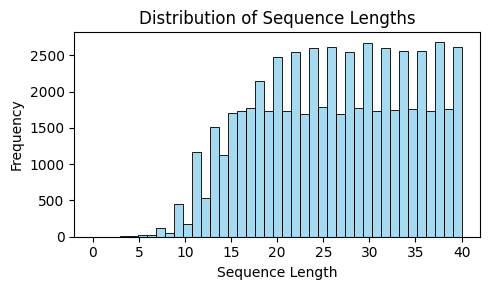

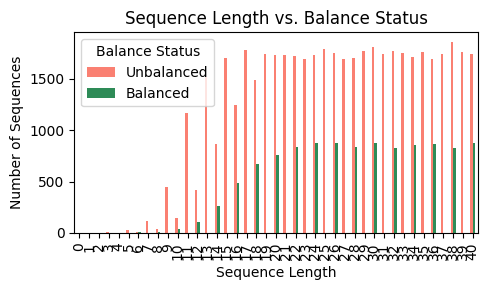

In [105]:
visualize_bracket_dataset(dataset_train)

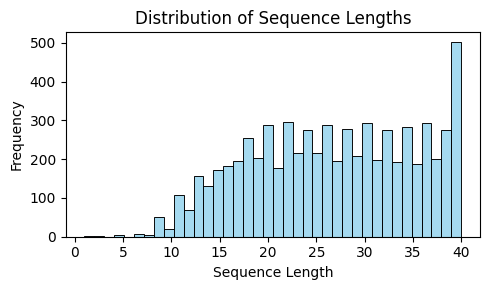

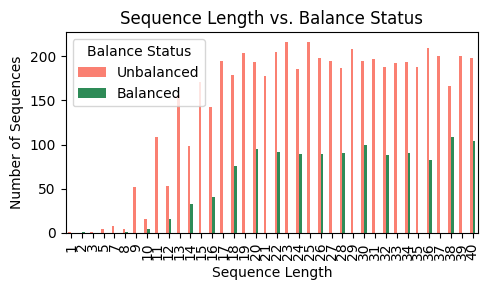

In [106]:
visualize_bracket_dataset(dataset_val)

# Training

In [107]:
import tqdm


def calculate_accuracy(
    preds: Float[torch.Tensor, "batch num_classes=2"],
    labels: Int[torch.Tensor, "batch"],
) -> float:
    """
    Calculate the overall accuracy of predictions.

    Args:
        preds (torch.Tensor): Predicted logits or probabilities, shape (batch_size, num_classes).
        labels (torch.Tensor): True labels, shape (batch_size).

    Returns:
        float: Overall accuracy.
    """
    _, pred_classes = torch.max(preds, dim=1)
    correct = pred_classes == labels
    return correct.float().mean().item()


def train_one_epoch(
    model: transformer_lens.HookedTransformer,
    dataloader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device,
    max_batches: int | None = None,
) -> tuple[float, float]:
    """
    Train the model for one epoch.

    Args:
        model (transformer_lens.HookedTransformer): The model to train.
        dataloader (DataLoader): DataLoader for training data.
        criterion (nn.Module): Loss function.
        optimizer (optim.Optimizer): Optimizer.
        device (torch.device): Device to run the training on.
        max_batches (int | None): Maximum number of batches to process.

    Returns:
        tuple[float, float]: Average training loss and accuracy.
    """
    model.train()

    running_loss = 0.0
    running_acc = 0.0
    total_samples = 0

    for batch_index, batch in tqdm.tqdm(enumerate(dataloader), desc="Training", leave=False):

        if max_batches is not None and batch_index >= max_batches:
            break

        _, labels, inputs = batch  # batch is (strs, isbal, toks)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs: Float[torch.Tensor, "batch seq num_classes=2"] = model(inputs)

        # note: this is because we throw away everything but the first position
        logits: Float[torch.Tensor, "batch num_classes=2"] = outputs[:, 0]

        loss = criterion(logits, labels)

        loss.backward()

        optimizer.step()

        batch_size = inputs.size(0)
        total_samples += batch_size
        running_loss += loss.item() * batch_size

        # Calculate accuracy for this batch
        batch_acc = calculate_accuracy(logits, labels)
        running_acc += batch_acc * batch_size

    epoch_loss = running_loss / total_samples
    epoch_acc = running_acc / total_samples

    return epoch_loss, epoch_acc


def evaluate(
    model: transformer_lens.HookedTransformer,
    dataloader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> tuple[float, float]:
    """
    Evaluate the model on the validation set.

    Args:
        model (transformer_lens.HookedTransformer): The model to evaluate.
        dataloader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to run the evaluation on.

    Returns:
        tuple[float, float]: Average validation loss and accuracy
    """
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="Evaluating", leave=False):

            _, labels, inputs = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs: Float[torch.Tensor, "batch seq num_classes=2"] = model(inputs)

            # note: this is because we throw away everything but the first position
            logits: Float[torch.Tensor, "batch num_classes=2"] = outputs[:, 0]
            loss = criterion(logits, labels)
            acc = calculate_accuracy(logits, labels)

            batch_size = inputs.size(0)
            total_samples += batch_size
            running_loss += loss.item() * batch_size
            running_acc += acc * batch_size

    # Calculate epoch metrics
    epoch_loss = running_loss / total_samples
    epoch_acc = running_acc / total_samples

    return epoch_loss, epoch_acc

In [108]:
import wandb


# === Helper Functions for Logging and Printing ===
def print_accuracy_metrics(acc: float, prefix: str = ""):
    """Print accuracy metrics for a given dataset."""
    print(f"{prefix}Overall Acc: {acc*100:.2f}%")
    # Note: Detailed per-class and per-length metrics are no longer available


def log_metrics_to_wandb(
    train_loss: float,
    train_acc: float,
    val_loss: float,
    val_acc: float,
    epoch: int,
) -> None:
    """Log metrics to wandb."""
    log_dict = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "epoch": epoch,
    }

    # Note: Per-class and per-length accuracies are no longer available

    wandb.log(log_dict)

## Overfit on small batch first

In [109]:
from dataclasses import dataclass


# note: you can directly use the wandb config!
@dataclass
class TrainConfig:
    num_epochs: int = 10
    batch_size: int = Constants.BATCH_SIZE
    learning_rate: float = 1e-4
    max_length: int = Constants.MAX_SAMPLE_SIZE_TRAIN
    eval_every_n_epochs: int = 1
    random_seed: int = 42
    max_batches_train: int | None = 100


train_cfg = TrainConfig()

# Initialize wandb
wandb.init(project="balanced_brackets_classification_v2", config=dataclasses.asdict(train_cfg))

model_cfg = make_model_config()
model = create_model(cfg=model_cfg, tokenizer=tokenizer)

# === Define Loss Function and Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=train_cfg.learning_rate, weight_decay=0.1)

# === Training Loop ===
for epoch in range(1, train_cfg.num_epochs + 1):

    train_loss, train_acc = train_one_epoch(
        model, dataloader_train, criterion, optimizer, device, train_cfg.max_batches_train
    )

    # Print training metrics
    print(
        f"[Epoch {epoch}/{train_cfg.num_epochs}] Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.6f}"
    )

    # Log every `eval_every_n_epochs` or at the end
    if (epoch % train_cfg.eval_every_n_epochs) == 0 or epoch == train_cfg.num_epochs:

        val_loss, val_acc = evaluate(model, dataloader_val, criterion, device)

        # Log metrics to wandb
        log_metrics_to_wandb(train_loss, train_acc, val_loss, val_acc, epoch)

        # Print validation metrics
        print(
            f"[Epoch {epoch}/{train_cfg.num_epochs}] Val Loss: {val_loss:.6f}, Val Acc: {val_acc:.6f}"
        )

# Finish the wandb run
wandb.finish()

Moving model to device:  mps


[Epoch 1/10] Train Loss: 0.452351, Train Acc: 0.820781


[Epoch 1/10] Val Loss: 0.405536, Val Acc: 0.820884


[Epoch 2/10] Train Loss: 0.265366, Train Acc: 0.877812


[Epoch 2/10] Val Loss: 0.135534, Val Acc: 0.947266


[Epoch 3/10] Train Loss: 0.119904, Train Acc: 0.953125


[Epoch 3/10] Val Loss: 0.107472, Val Acc: 0.956379


[Epoch 4/10] Train Loss: 0.069949, Train Acc: 0.972812


[Epoch 4/10] Val Loss: 0.056954, Val Acc: 0.978936


[Epoch 5/10] Train Loss: 0.031429, Train Acc: 0.989844


[Epoch 5/10] Val Loss: 0.023611, Val Acc: 0.992082


[Epoch 6/10] Train Loss: 0.018962, Train Acc: 0.994062


[Epoch 6/10] Val Loss: 0.017113, Val Acc: 0.994174


[Epoch 7/10] Train Loss: 0.007834, Train Acc: 0.998750


[Epoch 7/10] Val Loss: 0.008816, Val Acc: 0.997759


[Epoch 8/10] Train Loss: 0.008624, Train Acc: 0.998437


[Epoch 8/10] Val Loss: 0.031368, Val Acc: 0.988049


[Epoch 9/10] Train Loss: 0.046240, Train Acc: 0.983750


[Epoch 9/10] Val Loss: 0.111568, Val Acc: 0.954736


[Epoch 10/10] Train Loss: 0.021948, Train Acc: 0.992656


[Epoch 10/10] Val Loss: 0.011743, Val Acc: 0.996415


In [ ]:
transformer_lens.utils.

## Load Test Dataset

In [ ]:
"""
Each training example consists of [start], up to 40 parens, [end], and then as many [pad] as necessary.

In the dataset we're using, half the sequences are balanced, and half are unbalanced. Having an equal distribution is on purpose to make it easier for the model.
"""

import pathlib
import json

bracket_data_filepath = pathlib.Path(
    "gpt_from_scratch/ARENA_3.0/"
    "chapter1_transformer_interp/exercises/"
    "part51_balanced_bracket_classifier/brackets_data.json"
).resolve()

assert bracket_data_filepath.exists()

N_SAMPLES = 5000
with open(bracket_data_filepath, "rt") as file:
    data_tuples: tuple[str, bool] = json.load(file)
    print(f"loaded {len(data_tuples)} examples")

assert isinstance(data_tuples, list)

data_tuples = data_tuples[:N_SAMPLES]
data = BracketsDataset(data_tuples).to(device)
data_mini = BracketsDataset(data_tuples[:100]).to(device)

loaded 100000 examples


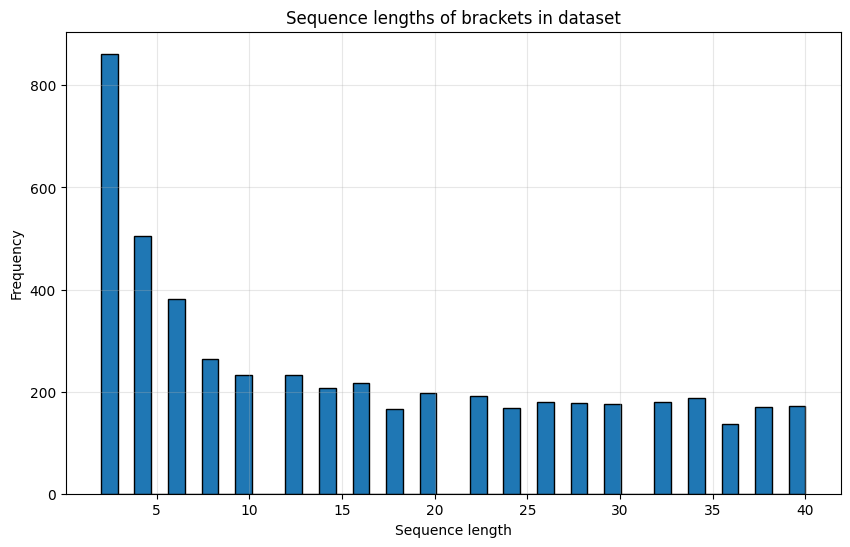

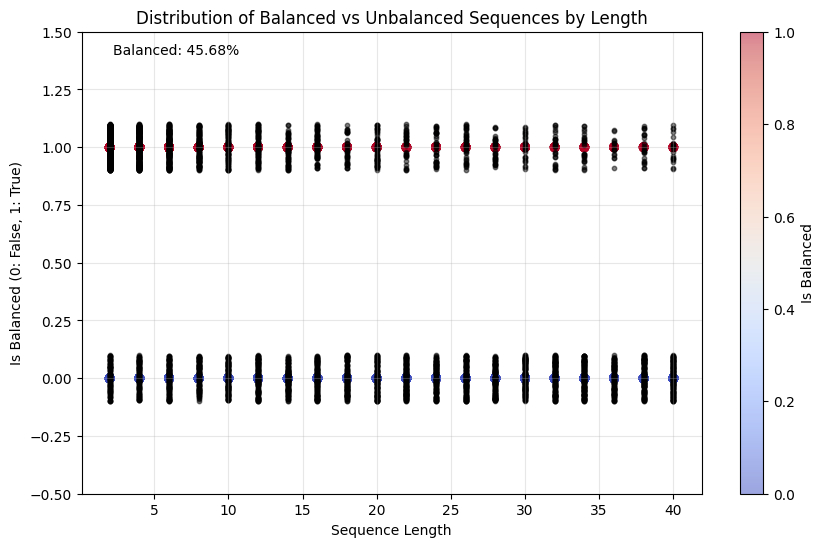

Total sequences: 5000
Balanced sequences: 2284 (45.68%)
Unbalanced sequences: 2716 (54.32%)
Average length: 16.01
Median length: 14.00
Min length: 2
Max length: 40


In [ ]:
data_mini[5]

('(()(()()())())',
 tensor(True, device='mps:0'),
 tensor([0, 3, 3, 4, 3, 3, 4, 3, 4, 3, 4, 4, 3, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='mps:0'))